## General Description

### Intercomparison of 3D Radiation Codes (I3RC): https://i3rc.gsfc.nasa.gov/
----

I3RC is an ongoing project initiated in the late 1990s. Its goals include: 
- Comparing methods available for 3D atmospheric radiative transfer calculations.
- Providing benchmark results for testing and debugging 3D radiative transfer codes.
- Publishing an open source toolkit (community 3D Monte Carlo code).
- Helping atmospheric science education by creating an archive of illustrative images and other resources on 3D radiative transfer.

Benchmark test-cases are devided into three phases. This notebook implements them for the mitsuba-renderer (https://www.mitsuba-renderer.org/), comparing it to gold-standard atmospheric science codes.

---
##### Phase I
Includes several baseline radiative computations for 3D radiative transfer through the following cloud fields:
1. 1D academic 'step' cloud field
2. 2D field derived from the ARM cloud radar
3. 3D field derived from radiances measured by the Landsat Thematic Mapper instrument

These computations involved cloud and surface only (i.e., no gases or aerosol) and were monochromatic, with scattering and absorption only (i.e., no emission), and were completed independently at each participants' home institutions.

---
#### Outputs

Mean and higher order moments of: 
   1. albedo (R)
   2. transmittance (T)
   3. absorptance (wherever applicable) (A)
   4. net horizontal flux (H) defined as $1-R-T-A$
   5. nadir reflectivity (Iu) defined as $\pi\nu / (F \mu_0)$ where: 
       - $\nu$ - upward exiting radiance at 0 degrees
       - $\mu_0$ - cosine of the solar zenith angle
       - $F=1$ is the incident solar flux
   6. oblique reflectivities (Io) defined as $\pi N_o / (F\mu_0)$ where:
       - $N_o$ - upward exiting radiance at 60 degrees zenith and 0 and 180 degrees azimuth angles (i.e. two oblique reflectivities are requested)
   7. zenith transmissivity (Id) defined as $\pi N_d/(F\mu_0)$ where:
       - $N_d$ - downward exiting radiance at 180 degrees (requested only when SZA=60)


Higher order moments are calculated as 
$$ \frac{1}{N}\sum_{i=1}^N (x_i-\bar{x})^k, \quad k=2,6 \quad  N=32$$

---
#### Consensus Results :

http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar

File format: I3RC_cons_res_case1_exp#_RQ.txt 

http://i3rc.gsfc.nasa.gov/input/step_cloud/README.txt

#### Compare mitsuba to I3RC consensus results:
---

     Exp.#    
        1.    SZA = 0,  w0 = 1
        2.    SZA = 60, w0 = 1
        3.    SZA = 0,  w0 = 0.99
        4.    SZA = 60, w0 = 0.99
    
    "RQ" is the radiative quantity. RQ takes the following values:
        - RQ=R     (reflectance)
        - RQ=T     (transmittance)
        - RQ=A     (absorptance)
        - RQ=H     (net horizontal flux)
        - RQ=Iu    (nadir reflectivity)
        - RQ=I601  (reflectivity at 60 view, 0 azimuth)
        - RQ=I602  (reflectivity at 60 view, 180 azimuth)
        - RQ=Id    (zenith transmissivity) 

## Intialization Cells

In [1]:
" Load imports requiered for this notebook "
# Mitsuba imports
from mitsuba.core import *
from mitsuba.render import Scene, RenderQueue, RenderJob

# Other imports 
import numpy as np
import matplotlib.pyplot as plt
import os, sys 
from tqdm import tqdm
import multiprocessing
from IPython.display import clear_output

from mtspywrapper import pyMedium, pyParallelRaySensor, pySolarEmitter

scheduler = Scheduler.getInstance()
ncores = multiprocessing.cpu_count()

# Start up the scheduling system with one worker per local core
if not scheduler.isRunning():
    for i in range(0, ncores): 
        scheduler.registerWorker(LocalWorker(i, 'wrk%i' % i))
    scheduler.start()
    
MTSPATH = next(path for path in sys.path if path.endswith('mitsuba'))
BASEPATH = os.path.join(MTSPATH, 'notebooks','i3rc')

In [2]:
" Initialize functions requiered for this notebook "

def load_i3rc_results(result_folder, experiments):
    """Import consensus results from result folder."""
    
    i3rc_results = dict()
    result_file_names = os.listdir(result_folder)
    
    for exp in experiments:
        fname = [filename for filename in result_file_names if exp in filename]
        assert(len(fname) == 1), "Two or more experiment files with the same name: {}, {}.".format(fname[0], fname[1])     
        fpath = os.path.join(result_folder, fname[0])
        i3rc_results[exp] = np.loadtxt(fpath)
        
    return i3rc_results  
    

def render_scene(scene, ncores=32):
    
    # Parallel rendering using the blocksize parameter for speed
    queue = RenderQueue()
    size = scene.getSensor().getFilm().getSize()
    blocksize = max(np.divide(max(size.x, size.y), ncores), 1)
    scene.setBlockSize(blocksize) 
    bitmap = Bitmap(Bitmap.ELuminance, Bitmap.EFloat32, size)
    job = RenderJob('myRenderJob', scene, queue)
    job.start()
    queue.waitLeft(0)
    
    # Develop the camera's film 
    scene.getFilm().develop(Point2i(0, 0), size, Point2i(0, 0), bitmap)
    radiance = np.array(bitmap.buffer()) 
    return radiance

def experiment_to_scene_params(experiment):
    
    solar_azimuth = 0.0
    if exp.startswith('exp1'):
        solar_zenith, single_scattering_albedo = 0.0, 1.0
    elif exp.startswith('exp2'):
        solar_zenith, single_scattering_albedo = 60.0, 1.0
    elif exp.startswith('exp3'):
        solar_zenith, single_scattering_albedo = 0.0, 0.99
    elif exp.startswith('exp4'):
        solar_zenith, single_scattering_albedo = 60.0, 0.99
        
    if exp.endswith('Iu'):
        view_zenith, view_azimuth = 0.0, 0.0
    elif exp.endswith('I601'):
        view_zenith, view_azimuth = 60.0, 0.0
    elif exp.endswith('I602'):
        view_zenith, view_azimuth = 60.0, 180.0
    scene_params = {
        'solar_zenith': solar_zenith,
        'solar_azimuth': solar_azimuth,
        'view_zenith': view_zenith, 
        'view_azimuth': view_azimuth,
        'single_scattering_albedo': single_scattering_albedo
    }  
    
    return scene_params

def get_mitsuba_scene(scene_params, medium, sensor, emitter):
    """Define a mitsuba scene according to the medium, sensor and scene parameters"""
    
    scene = Scene()
    pmgr = PluginManager.getInstance()  
    # Set the integrator
    scene.addChild(pmgr.create({
        'type' : 'volpath_simple',
        'rrDepth' : scene_params['rr_depth']
    }))
    # Add the sensor 
    scene.addChild(sensor.get_mitsuba_sensor())
    # Add heterogeneous medium
    scene.addChild(medium.get_mitsuba_medium())
    # Create medium bounding box
    scene.addChild(medium.get_mitsuba_bounding_box())
    # Add Emitter
    scene.addChild(emitter.get_mitsuba_emitter())
    
    scene.configure()
    return scene

## 1D academic step cloud field

### Scenario 

- X-direction: $32$ columns (pixels): 16 have an optical depth of $\tau=2$. The remaining have $\tau=18$. Total size is 0.5km, thus $dx=0.5/32~ {\rm km}$.
- Y-direction: infinite.
- Z-direction: Geometrical thickness is set to 0.25 km everywhere (flat cloud).
   
  - Project page: https://i3rc.gsfc.nasa.gov/input/step_cloud/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/step_cloud/README.txt
  - Result file: http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case1.tar    

### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

### Code

In [3]:
# ---------------- Define the medium extinction and phase function ---------------- #
tau = np.hstack((np.full(16, 2.00), np.full(16, 18.00)))
bounding_box = [0, 0, 0, 0.5, 0.5, 0.25]   # [xmin, ymin, zmin, xmax, ymax, zmax] in km units
geometrical_thickness = bounding_box[5] - bounding_box[2]
beta = tau/geometrical_thickness
medium = pyMedium()
medium.set_density(beta, bounding_box)
medium.set_hg_phase(0.85)
medium.set_boundary(x='periodic', y='periodic')

In [4]:
experiments = ['exp1_Iu', 'exp2_Iu', 'exp4_Iu', 'exp1_I602', 'exp2_I602', 'exp4_I601']


# ---------------------- Render mitsuba results for case1 -------------------- #
scene_params = {
    'rr_depth': 300,
    'num_samples': 2**15
}
sensor = pyParallelRaySensor(medium)
sensor.set_sampler(scene_params['num_samples'])
solar_emitter = pySolarEmitter()

mitsuba_results = dict()
for i, exp in enumerate(experiments):
    # Set up the mitsuba scene fo this experiment 
    scene_params.update(experiment_to_scene_params(exp))
    sensor.set_world_transform(scene_params['view_zenith'], scene_params['view_azimuth'])
    medium.set_single_scattering_albedo(scene_params['single_scattering_albedo'])
    solar_emitter.set_solar_angles(scene_params['solar_zenith'], scene_params['solar_azimuth'])
    scene = get_mitsuba_scene(scene_params, medium, sensor, solar_emitter)
    
    # Render the scene using multiple cores
    clear_output(wait=True)
    print 'rendering experiment {}: {}'.format(i+1, exp)
    mitsuba_results[exp] = render_scene(scene, ncores=ncores) * solar_emitter.brf_factor
print('Finished rendering!')


# -------------------- Load i3rc consensus results for case1 ----------------- #
result_folder = os.path.join(BASEPATH, 'case1','consensus_results')
i3rc_results = load_i3rc_results(result_folder, experiments)
print('i3rc results loaded!')

rendering experiment 6: exp4_I601
Finished rendering!
i3rc results loaded!


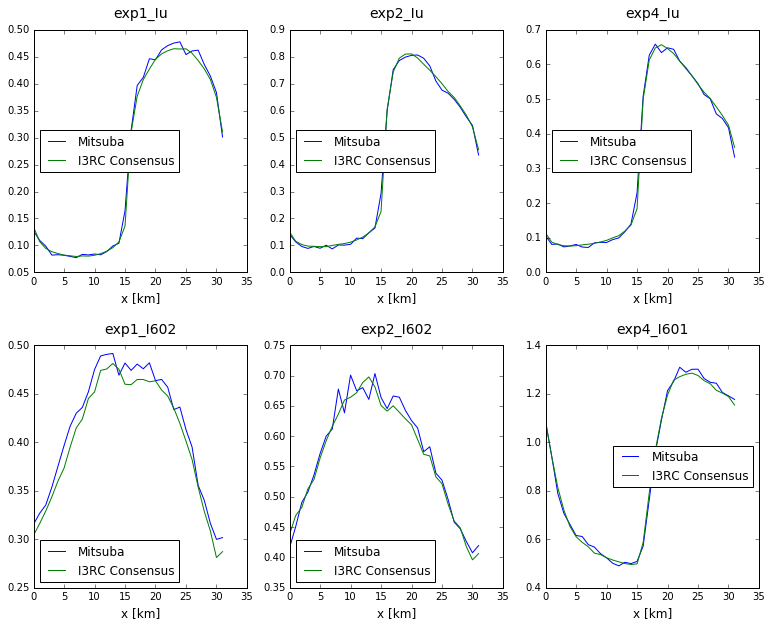

In [21]:
# ---------------------- Plot comparison graphs ------------------- #
%matplotlib inline 

num_rows = np.ceil(len(experiments)/3.0).astype(np.int)
num_cols = min(3,len(experiments))
f, axarr = plt.subplots(num_rows, num_cols, figsize=(13, 5*num_rows));
if isinstance(axarr, np.ndarray):
    axarr = axarr.ravel()
else:
    axarr = [axarr]
for ax, exp in zip(axarr, experiments):
    ax.plot(mitsuba_results[exp].T, label='Mitsuba');
    ax.plot(i3rc_results[exp], label='I3RC Consensus');
    ax.legend(fontsize=12, loc='best');
    ax.set_title('{}'.format(exp), fontsize=14, y=1.03); 
    ax.set_xlabel('x [km]', fontsize=12);
plt.subplots_adjust(hspace=0.3);

## 2D field derived from the ARM cloud radar

The 2D cloud field for this experiment is based on extinction retrievals from the MMCR (Millimiter Cloud Radar) and the MWR (microwave radiometer)at the ARM CART site in Lamont, OK on Feb. 8, 98. 

### Scenario 

- X-direction: 640 columns (pixels) each of size dx=50m: total width is 32km.
- Y-direction: Infinite.
- Z-direction: 54 vertical layers each of size dz=45m: total vertical size is 2.43km. 

  - Project page: https://i3rc.gsfc.nasa.gov/input/MMCR/high_res/020898/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/MMCR/high_res/020898/README.txt
  - Result file http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case2.tar    

### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x direction)
3. Henyey-Greenstein phase function (PF) with g=0.85 and C.1
   (Dermeindjian 1969)
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

### Code

In [6]:
# ---------------- Define the medium extinction and phase function ---------------- #
fileName = 'mmcr_tau_32km_020898'
beta = np.loadtxt(os.path.join(BASEPATH, 'case2', fileName)).T.reshape((640,1,54))[...,::-1]
beta /= 0.045   # It is given in inverse grid unit --> devide by 45m vertical resolution to get km^-1
bounding_box = [0, 0, 0, 32.0, 1, 2.43]   # [xmin, ymin, zmin, xmax, ymax, zmax] in km units

medium = pyMedium()
medium.set_density(beta, bounding_box)
medium.set_hg_phase(0.85)
medium.set_boundary(x='periodic', y='periodic')

In [9]:
experiments = ['exp1_Iu', 'exp2_Iu', 'exp4_Iu']

# ------------------------- Render mitsuba results ----------------------- #
scene_params = {
    'rr_depth': 300,
    'num_samples': 2**15
}
sensor = pyParallelRaySensor(medium)
sensor.set_sampler(scene_params['num_samples'])
solar_emitter = pySolarEmitter()

mitsuba_results = dict()
for i, exp in enumerate(experiments):
    # Set up the mitsuba scene fo this experiment 
    scene_params.update(experiment_to_scene_params(exp))
    sensor.set_world_transform(scene_params['view_zenith'], scene_params['view_azimuth'])
    medium.set_single_scattering_albedo(scene_params['single_scattering_albedo'])
    solar_emitter.set_solar_angles(scene_params['solar_zenith'], scene_params['solar_azimuth'])
    scene = get_mitsuba_scene(scene_params, medium, sensor, solar_emitter)
    
    # Render the scene using multiple cores
    clear_output(wait=True)
    print 'rendering experiment {}: {}'.format(i+1, exp)
    mitsuba_results[exp] = render_scene(scene, ncores=ncores) * solar_emitter.brf_factor
print('Finished rendering!')


# ----------------------- Load i3rc consensus results -------------------- #
result_folder = os.path.join(BASEPATH, 'case2','consensus_results')
i3rc_results = load_i3rc_results(result_folder, experiments)
print('i3rc results loaded!')

rendering experiment 3: exp4_Iu
Finished rendering!
i3rc results loaded!


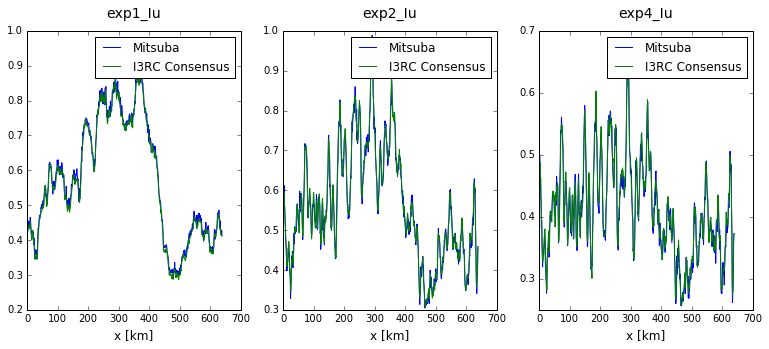

In [10]:
# ---------------------- Plot comparison graphs ------------------- #
%matplotlib inline 

num_rows = np.ceil(len(experiments)/3.0).astype(np.int)
num_cols = min(3,len(experiments))
f, axarr = plt.subplots(num_rows, num_cols, figsize=(13, 5*num_rows));
if isinstance(axarr, np.ndarray):
    axarr = axarr.ravel()
else:
    axarr = [axarr]
for ax, exp in zip(axarr, experiments):
    ax.plot(mitsuba_results[exp].T, label='Mitsuba');
    ax.plot(i3rc_results[exp], label='I3RC Consensus');
    ax.legend(fontsize=12, loc='best');
    ax.set_title('{}'.format(exp), fontsize=14, y=1.03); 
    ax.set_xlabel('x [km]', fontsize=12);
plt.subplots_adjust(hspace=0.3);

## 3D Landsat cloud case

The 2D cloud field for this experiment is from an Independent Approximation retrieval on a 128x128 segment of a Landsat-4 scene used in Oreopoulos and Davies, J. Climate, 11, 919-932, 1998. Band 4 (0.83 microns) was used.

### Scenario 

- X-direction: 128 columns(pixels) each of size dx=30: total width is 3.84km.
- Y-direction: 128 columns(pixels) each of size dx=30: total width is 3.84km.
- Z-direction: Homogeneous colums with optical and geometrical depth according to files. Cloud bottom at 0.2km and cloud top determined from the geometrical thickness.

  - Project page: https://i3rc.gsfc.nasa.gov/input/Landsat/index.html
  - Readme: https://i3rc.gsfc.nasa.gov/input/Landsat/README.txt
  - Result file http://i3rc.gsfc.nasa.gov/consensus_result/consensus_result_case2.tar    

### Experiments

ASSUMPTIONS:
1. No atmospheric effects
2. Periodic boundary conditions (cloud field is repeated an infinite
   number of times along the x and y directions)
3. Henyey-Greenstein phase function (PF) with g=0.85.
4. Black (zero reflectance) surface
5. Single scattering albedos w0=1 and w0=0.99 (with the same PF
   and extinction field).

SOLAR GEOMETRY: 
1. Sun at (SZA of) zero degrees
2. Sun at 60 degrees and 0 azimuth (Sun shining from low x coordinates)

### code

In [3]:
# ------------------ Define the medium extinction and phase function ------------------ #
geometrical_thickness = np.loadtxt(os.path.join(BASEPATH, 'case3', 'scene43.dz.128x128'))
tau = np.loadtxt(os.path.join(BASEPATH, 'case3', 'scene43.tau.128x128'))

nx, ny, nz = 128, 128, 128
dz = geometrical_thickness.max()/nz
num_cells_occupied = np.round(geometrical_thickness/dz).astype(np.int)
rounded_geometrical_thickness = num_cells_occupied*dz
beta_2d = np.divide(tau, rounded_geometrical_thickness, 
                    out=np.zeros_like(tau), where=rounded_geometrical_thickness!=0)
beta_3d = np.zeros(shape=(nx, ny, nz))
for y in range(ny): 
    for x in range(nx):
        beta_3d[x,y,:num_cells_occupied[x,y]] = beta_2d[x,-1-y]    # Note inverted Y axis according to readme
bounding_box = [0, 0, 0, 3.84, 3.84, geometrical_thickness.max()]  # [xmin, ymin, zmin, xmax, ymax, zmax] in km units

medium = pyMedium()
medium.set_density(beta_3d, bounding_box)
medium.set_hg_phase(0.85)
medium.set_boundary(x='periodic', y='periodic')

In [5]:
experiments = ['exp1_Iu']

# ------------------------- Render mitsuba results ----------------------- #
scene_params = {
    'rr_depth': 300,
    'num_samples': 2**12
}
sensor = pyParallelRaySensor(medium)
sensor.set_sampler(scene_params['num_samples'])
solar_emitter = pySolarEmitter()

mitsuba_results = dict()
for i, exp in enumerate(experiments):
    # Set up the mitsuba scene fo this experiment 
    scene_params.update(experiment_to_scene_params(exp))
    sensor.set_world_transform(scene_params['view_zenith'], scene_params['view_azimuth'])
    medium.set_single_scattering_albedo(scene_params['single_scattering_albedo'])
    solar_emitter.set_solar_angles(scene_params['solar_zenith'], scene_params['solar_azimuth'])
    scene = get_mitsuba_scene(scene_params, medium, sensor, solar_emitter)
    
    # Render the scene using multiple cores
    clear_output(wait=True)
    print 'rendering experiment {}: {}'.format(i+1, exp)
    mitsuba_results[exp] = render_scene(scene, ncores=ncores) * solar_emitter.brf_factor
print('Finished rendering!')


# ----------------------- Load i3rc consensus results -------------------- #
result_folder = os.path.join(BASEPATH, 'case3','consensus_results')
i3rc_results = load_i3rc_results(result_folder, experiments)
print('i3rc results loaded!')

rendering experiment 1: exp1_Iu
Finished rendering!
i3rc results loaded!


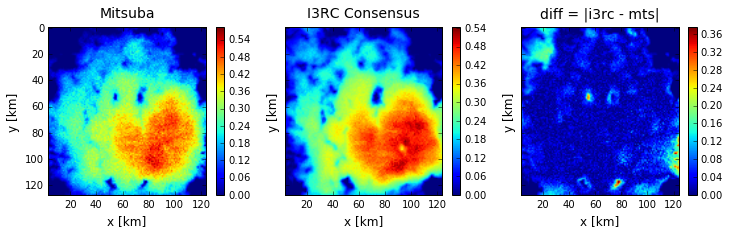

In [6]:
# ---------------------- Plot comparison graphs ------------------- #
%matplotlib inline 

num_rows, num_cols = len(experiments), 3
f, axarr = plt.subplots(num_rows, num_cols, figsize=(12, 3*num_rows), sharey=True);
if axarr.ndim==1:
    axarr = axarr[None]
img = [None]*3
for ax, exp in zip(axarr, experiments):
    img[0] = ax[0].imshow(mitsuba_results[exp].T);
    ax[0].set_title('Mitsuba', fontsize=14, y=1.03)
    ax[0].set_xlabel('x [km]', fontsize=12);
    ax[0].set_ylabel('y [km]', fontsize=12);
    img[1] = ax[1].imshow(i3rc_results[exp]);
    ax[1].set_title('I3RC Consensus', fontsize=14, y=1.03)
    ax[1].set_xlabel('x [km]', fontsize=12);
    ax[1].set_ylabel('y [km]', fontsize=12);
    img[2] = ax[2].imshow(np.abs(i3rc_results[exp] - mitsuba_results[exp].T))
    ax[2].set_title('diff = |i3rc - mts|', fontsize=14, y=1.03)
    for i,colax in enumerate(ax):
        colax.set_xlabel('x [km]', fontsize=12);
        colax.set_ylabel('y [km]', fontsize=12);
        plt.colorbar(img[i], ax=colax)